In [1]:
# Imports
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Flatten, Input
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical

import glob
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

In [2]:
# Constantes
IMAGE_SIZE = 128
CLASSES = ['TOEI', 'GB', 'WIT', 'DSN']

In [3]:
!git clone https://github.com/Cooleure/BD_Animes.git
files_path = "./BD_Animes/"

fatal: destination path 'BD_Animes' already exists and is not an empty directory.


In [4]:
# Load data
def load_data(folder_path, classes, image_size=64):

  # Place aléatoirement les images dans les sous-ensembles train, validation et test
  # En récupérant les images dans chaque dossier film

  # Initialisation des sous-ensembles
  train = {'x': [], 'y': []}
  validation = {'x': [], 'y': []}
  test = {'x': [], 'y': []}
  test_inedit = {'x': [], 'y': []}

  # Liste les dossiers de films présents dans le dossier path
  files = glob.glob(folder_path + "/**/*.jpg", recursive = True)
  # print(files)
  x_and_y_tuple = []
  x_and_y_tuple_inedit = []

  # Load data pour chaque film
  ignore_terms = ["kabaneri", "marnie", "hokuto", "bambi"]

  for file in files:
    if any(term in file.lower() for term in ignore_terms):
      x_and_y_tuple_inedit.append(load_data_movie_file(file, classes, image_size))
    else:
      x_and_y_tuple.append(load_data_movie_file(file, classes, image_size))

  # Nombre d'images
  n = len(x_and_y_tuple)
  n_inedit = len(x_and_y_tuple_inedit)

  # Indices aléatoires
  indices = np.random.permutation(n)

  # Séparation des données
  train_indices = indices[:int(0.6*n)]
  validation_indices = indices[int(0.6*n):int(0.9*n)]
  test_indices = indices[int(0.9*n):]
  test_inedit_indices = np.random.permutation(n_inedit)

  # Ajout des données
  train['x'] = np.array([x_and_y_tuple[i][0] / 255.0 for i in train_indices])
  train['y'] = np.array([x_and_y_tuple[i][1] for i in train_indices])
  validation['x'] = np.array([x_and_y_tuple[i][0] / 255.0 for i in validation_indices])
  validation['y'] = np.array([x_and_y_tuple[i][1] for i in validation_indices])
  test['x'] = np.array([x_and_y_tuple[i][0] / 255.0 for i in test_indices])
  test['y'] = np.array([x_and_y_tuple[i][1] for i in test_indices])
  test_inedit['x'] = np.array([x_and_y_tuple_inedit[i][0] / 255.0 for i in test_inedit_indices])
  test_inedit['y'] = np.array([x_and_y_tuple_inedit[i][1] for i in test_inedit_indices])

  return train, validation, test, test_inedit

def load_data_movie_file(file, classes, image_size=64):
  # Lecture de l'image + mise à l'échelle
  img = Image.open(file)
  img = img.resize((image_size, image_size), Image.LANCZOS)

  # Image + Label
  x = np.asarray(img)
  y = load_label(file, classes)

  return x, y

def load_label(path, classes):
  img_path_split = path.split('/')
  img_name_split = img_path_split[-1].split('_')
  return classes.index(img_name_split[0])


In [5]:
def plot_training_analysis(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def confusionMatrix(actual, predictions, title):
    predicted = [np.argmax(i) for i in predictions]

    # Matrice de confusion brute
    conf_matrix = confusion_matrix(actual, predicted)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=CLASSES)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    cm_display.plot(ax=plt.gca())
    plt.title("Matrice de Confusion Brute")

    # Matrice de confusion normalisée
    conf_matrix_normalized = confusion_matrix(actual, predicted, normalize='true')
    cm_display_normalized = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=CLASSES)

    plt.subplot(1, 2, 2)
    cm_display_normalized.plot(cmap='Blues', ax=plt.gca())
    plt.title("Matrice de Confusion Normalisée")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [6]:
def exportModel(model, modelName):
  from google.colab import drive
  drive.mount('/content/drive')
  model.save('/content/drive/MyDrive/ApprentissageProfond/' + modelName)

In [8]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet152V2

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, LeakyReLU

def transferLearningModel(model_name="VGG16", image_size=IMAGE_SIZE, weights='imagenet', epochs=10, fine_tuning=False):
    print("TRANSFER LEARNING")
    print("------------------------------")
    print("Conv")

    if model_name == "VGG16":
        conv = VGG16(weights=weights, include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "VGG19":
        conv = VGG19(weights=weights, include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "Xception":
        conv = Xception(weights=weights, include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "ResNet152V2":
        conv = ResNet152V2(weights=weights, include_top=False, input_shape=(image_size, image_size, 3))

    conv.trainable = fine_tuning
    conv.summary()
    output_shape = np.prod(conv.output_shape[1:])

    train_features = conv.predict(train['x'])
    train_features = np.reshape(train_features, (train_features.shape[0], output_shape))

    val_features = conv.predict(val['x'])
    val_features = np.reshape(val_features, (val_features.shape[0], output_shape))

    test_features = conv.predict(test['x'])
    test_features = np.reshape(test_features, (test_features.shape[0], output_shape))

    test_inedit_features = conv.predict(test_inedit['x'])
    test_inedit_features = np.reshape(test_inedit_features, (test_inedit_features.shape[0], output_shape))

    print("------------------------------")
    print("Model")

    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=output_shape, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    model.summary()

    rate = 3e-5 if fine_tuning else 3e-4

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=rate),
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(train_features, to_categorical(train['y']),
                        epochs=epochs,
                        batch_size=50,
                        validation_data=(test_inedit_features, to_categorical(test_inedit['y'])),
                        )

    plot_training_analysis(history)

    print("Test")
    confusionMatrix(test['y'], model.predict(test_features), title="Jeu de test")

    print("Test inedit")
    confusionMatrix(test_inedit['y'], model.predict(test_inedit_features), title="Jeu de test, films inédits")

    return model


In [37]:
def transferLearningModelComplex(model_name="VGG16", image_size=IMAGE_SIZE, weights='imagenet', epochs=10, fine_tuning=False):
    print("TRANSFER LEARNING")
    print("------------------------------")
    print("Conv")

    if model_name == "VGG16":
        conv = VGG16(weights=weights, include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "VGG19":
        conv = VGG19(weights=weights, include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "Xception":
        conv = Xception(weights=weights, include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "ResNet152V2":
        conv = ResNet152V2(weights=weights, include_top=False, input_shape=(image_size, image_size, 3))

    conv.trainable = fine_tuning
    conv.summary()
    output_shape = np.prod(conv.output_shape[1:])

    train_features = conv.predict(train['x'])
    train_features = np.reshape(train_features, (train_features.shape[0], output_shape))

    val_features = conv.predict(val['x'])
    val_features = np.reshape(val_features, (val_features.shape[0], output_shape))

    test_features = conv.predict(test['x'])
    test_features = np.reshape(test_features, (test_features.shape[0], output_shape))

    test_inedit_features = conv.predict(test_inedit['x'])
    test_inedit_features = np.reshape(test_inedit_features, (test_inedit_features.shape[0], output_shape))

    print("------------------------------")
    print("Model")

    model = Sequential()

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_dim=output_shape))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))

    model.summary()

    rate = 3e-5 if fine_tuning else 3e-4

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=rate),
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(train_features, to_categorical(train['y']),
                        epochs=epochs,
                        batch_size=10,
                        validation_data=(test_inedit_features, to_categorical(test_inedit['y'])),
                        callbacks=[early_stopping])

    plot_training_analysis(history)

    print("Test")
    confusionMatrix(test['y'], model.predict(test_features), title="Jeu de test")

    print("Test inedit")
    confusionMatrix(test_inedit['y'], model.predict(test_inedit_features), title="Jeu de test, films inédits")

    # Prédictions exemples
    indices = np.arange(len(test['x']))
    np.random.shuffle(indices)

    plt.figure(figsize=(12, 12))

    for i in range(0, 9):
        plt.subplot(3, 3, i+1)
        random_index = indices[i]  # Utiliser les indices aléatoires

        classe_attendue = str(CLASSES[int(test['y'][random_index])])
        classe_predite = str(CLASSES[np.argmax(model.predict(test_features)[random_index])])

        plt.title("true : " + classe_attendue + " / pred : " + classe_predite)
        plt.imshow(test['x'][random_index])

    plt.suptitle("Prédictions")
    plt.tight_layout()
    plt.show()

    return model

In [6]:
# Train, validation, test
train, val, test, test_inedit = load_data(files_path, CLASSES, image_size=IMAGE_SIZE)

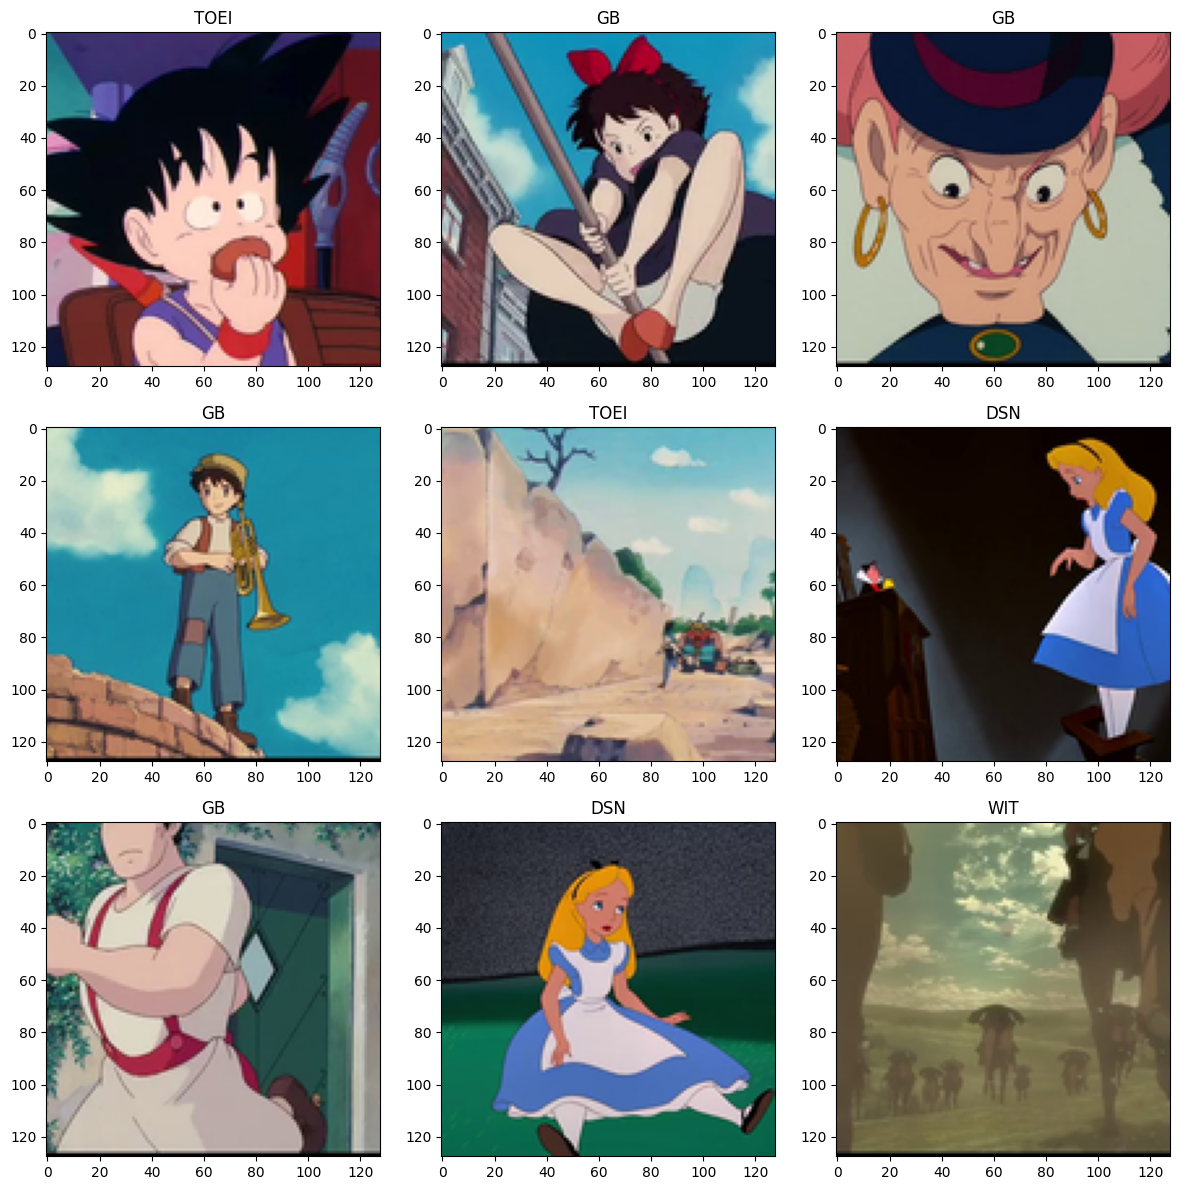

In [32]:
# Randomisation des indices
indices = np.arange(len(train['x']))
np.random.shuffle(indices)

# Affichage de 9 images aléatoires de la base d'apprentissage
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    random_index = indices[i]  # Utiliser les indices aléatoires
    plt.title(CLASSES[int(train['y'][random_index])])
    plt.imshow(train['x'][random_index])
plt.tight_layout()
plt.show()

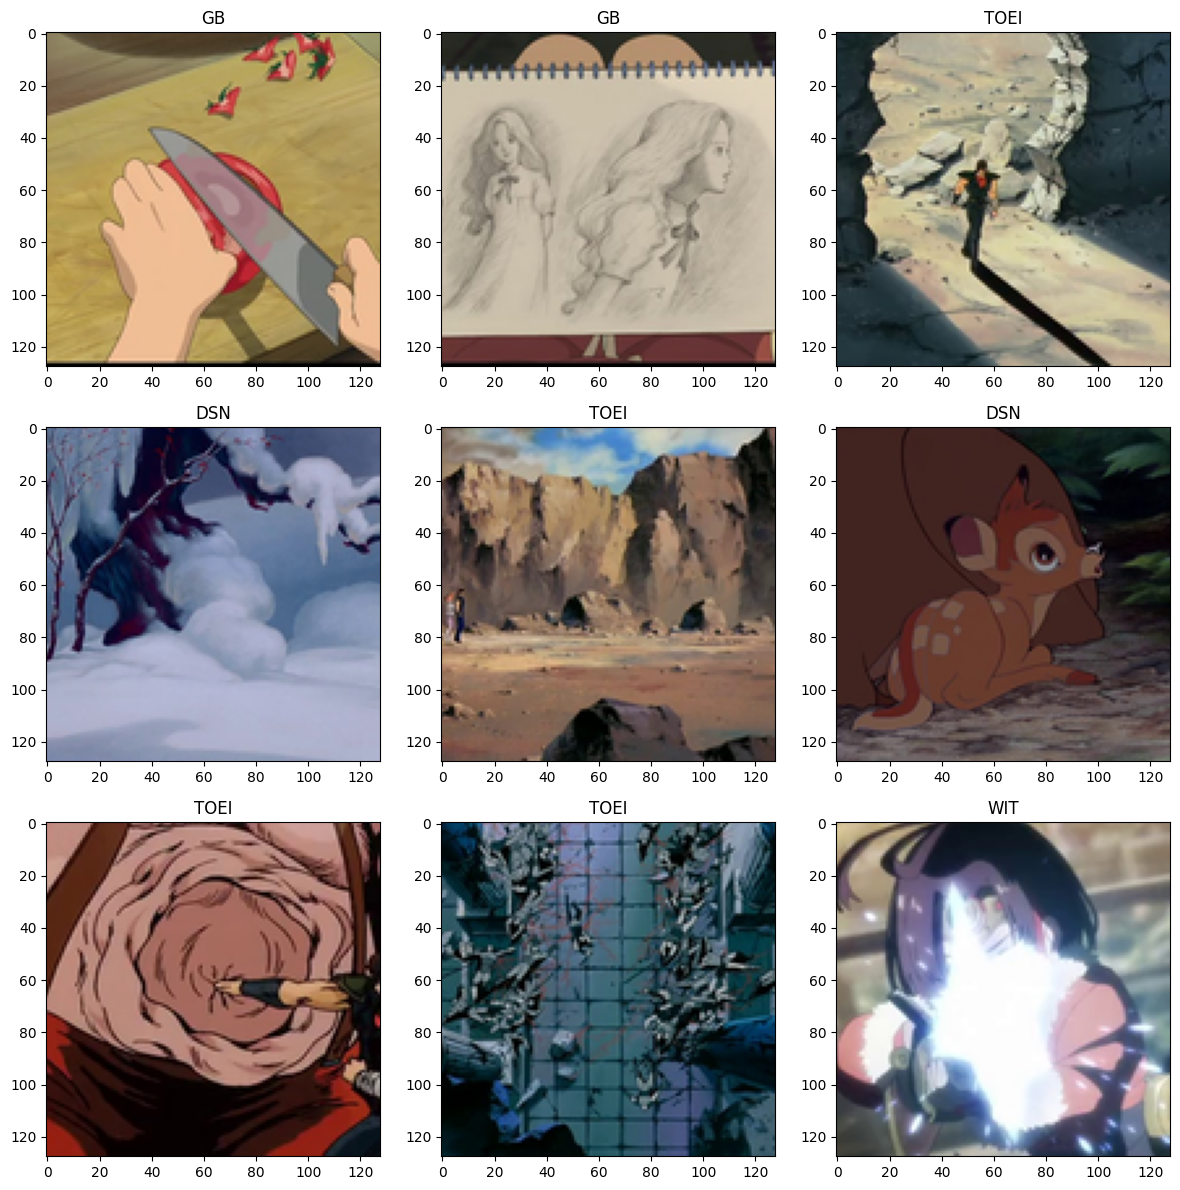

In [33]:
# Test inédits
# Randomisation des indices
indices = np.arange(len(test_inedit['x']))
np.random.shuffle(indices)

# Affichage de 9 images aléatoires de la base d'apprentissage
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    random_index = indices[i]  # Utiliser les indices aléatoires
    plt.title(CLASSES[int(test_inedit['y'][random_index])])
    plt.imshow(test_inedit['x'][random_index])
plt.tight_layout()
plt.show()

{0: 1004, 1: 1482, 2: 1537, 3: 545}


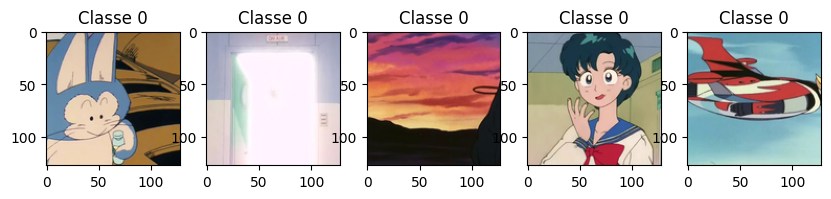

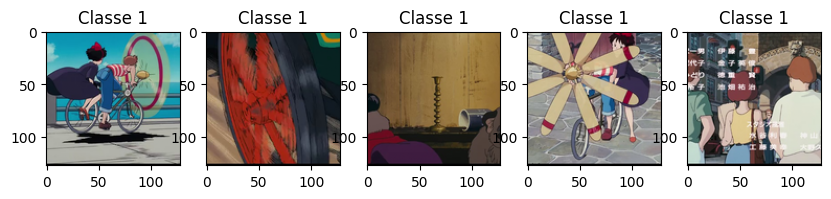

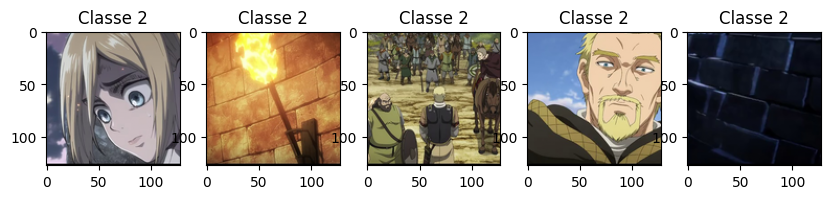

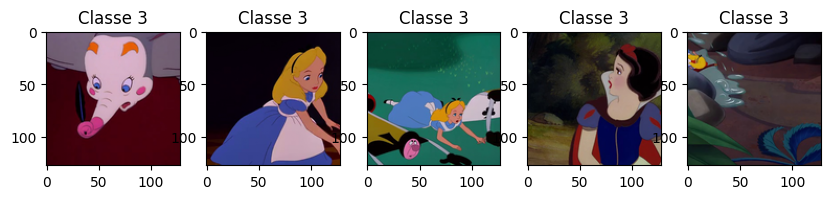

In [22]:
# Vérification de l'équilibre des classes

# Compter le nombre d'exemples pour chaque classe
unique, counts = np.unique(to_categorical(train['y']).argmax(axis=1), return_counts=True)
print(dict(zip(unique, counts)))

for i in range(4):  # Pour chaque classe
    indices = np.where(to_categorical(train['y']).argmax(axis=1) == i)[0]
    plt.figure(figsize=(10, 2))
    for j in range(5):  # Afficher 5 images par classe
        plt.subplot(1, 5, j+1)
        plt.imshow(train['x'][indices[j]])
        plt.title(f"Classe {i}")
    plt.show()

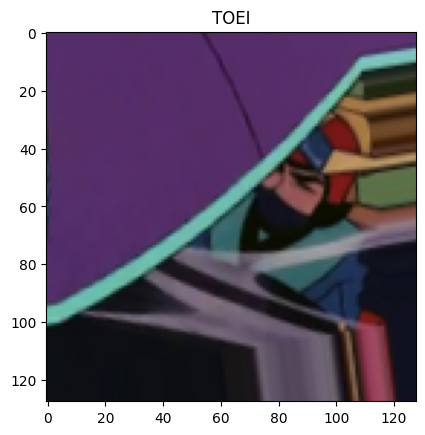

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation des données - génération d'images
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

example_x, example_y = train_datagen.flow(train['x'], train['y'], batch_size=1).next()
for i in range(0,1):
    plt.imshow(example_x[i])
    plt.title(CLASSES[int(example_y[i])])
    plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 64)       

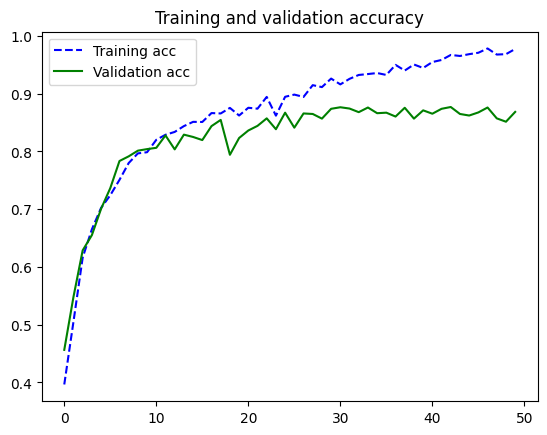

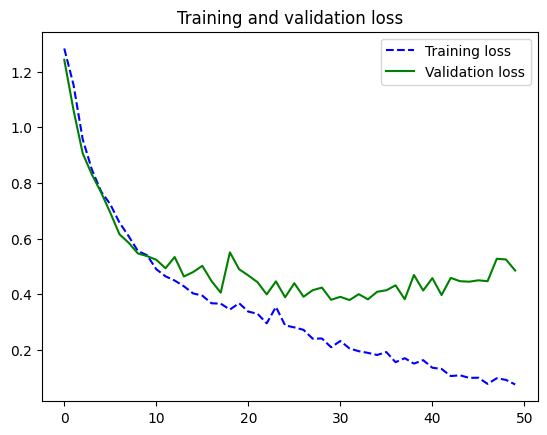

24/24 [==============================] - 1s 13ms/step


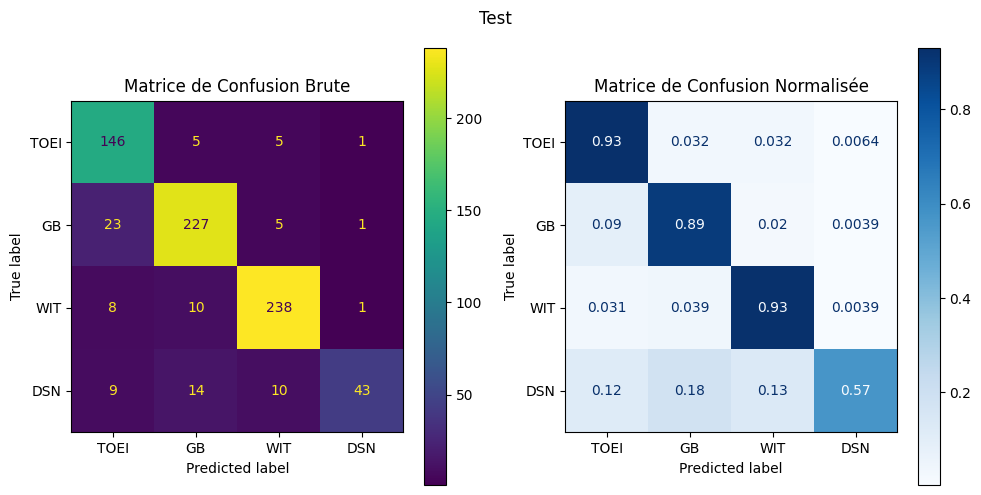

71/71 [==============================] - 1s 11ms/step


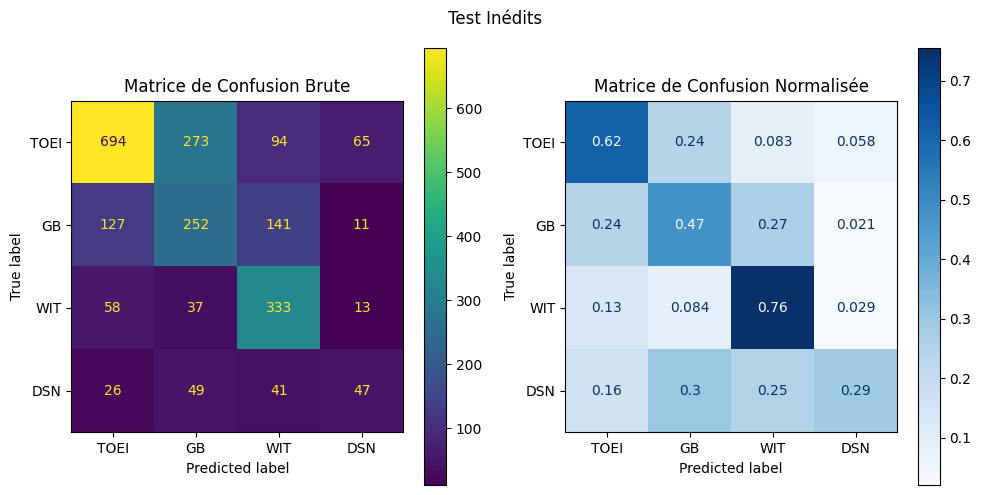

In [35]:
# AlexNet
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 1
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3
model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 5
model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense
model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(4, activation='softmax'))   # Couche de sortie

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])


history = model.fit(train['x'], to_categorical(train['y']),
                    validation_data=(val['x'], to_categorical(val['y'])),
                    epochs=50,
                    batch_size=100)

# history = model.fit(train_datagen.flow(train['x'], to_categorical(train['y']), batch_size=10),
#                     validation_data=(val['x'], to_categorical(val['y'])),
#                     epochs=50,
#                     batch_size=100)

plot_training_analysis(history)

confusionMatrix(test['y'], model.predict(test['x']), "Test")
confusionMatrix(test_inedit['y'], model.predict(test_inedit['x']), "Test Inédits")

In [ ]:
exportModel(model, 'AlexNetExtended')

TRANSFER LEARNING
------------------------------
Conv
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2

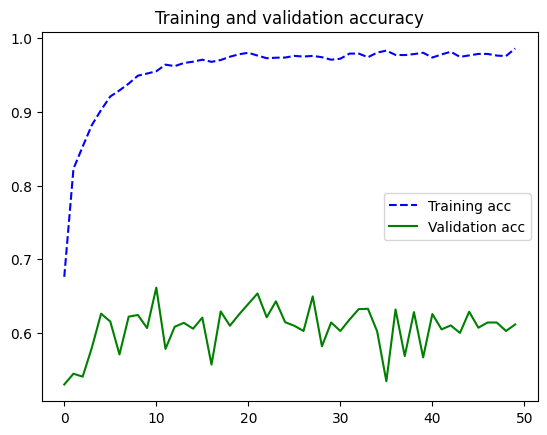

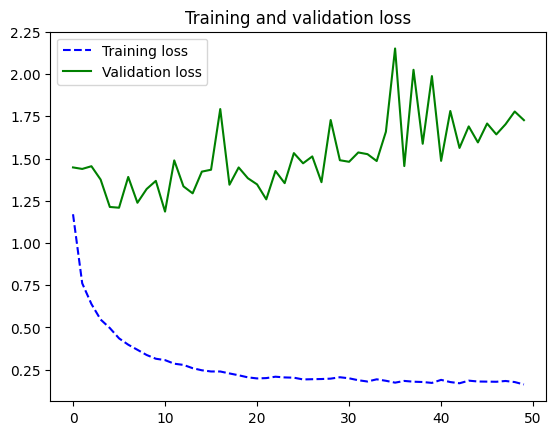

Test
24/24 [==============================] - 0s 2ms/step


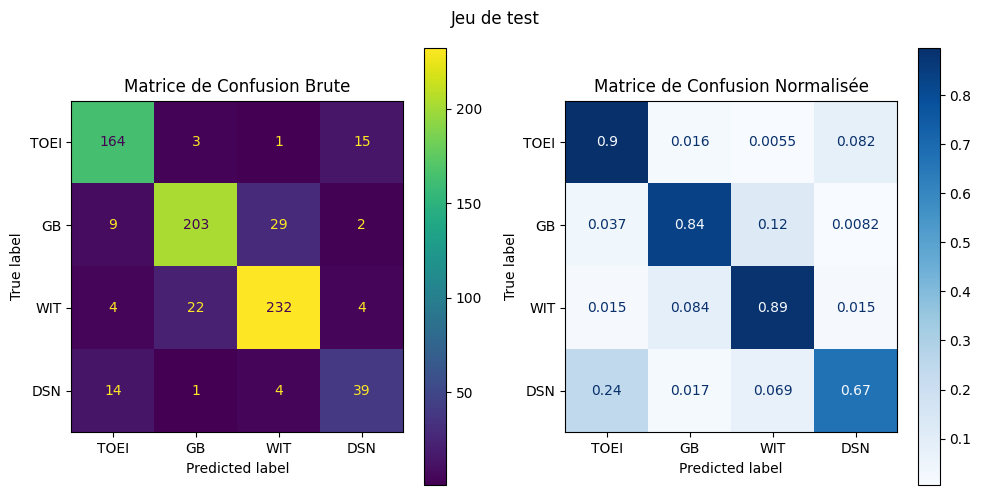

Test inedit
71/71 [==============================] - 0s 2ms/step


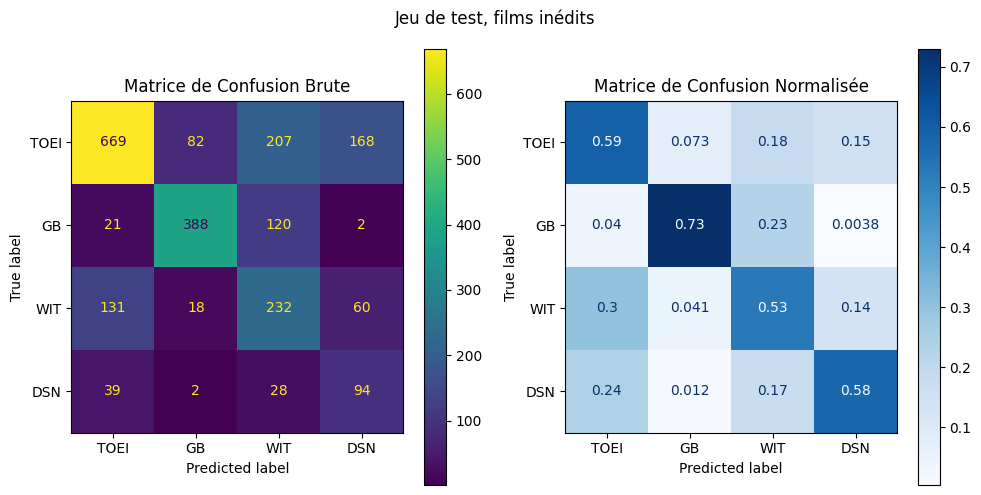

In [9]:
transferLearningModel(model_name="VGG16", epochs=50, fine_tuning=False)

In [ ]:
transferLearningModel(model_name="VGG19", epochs=50, fine_tuning=False)

In [ ]:
transferLearningModel(model_name="Xception", epochs=50, fine_tuning=False)

In [ ]:
transferLearningModel(model_name="ResNet152V2", epochs=50, fine_tuning=False)

In [7]:
transferLearningModel(model_name="VGG16", epochs=50, fine_tuning=True)

NameError: name 'transferLearningModel' is not defined

In [ ]:
transferLearningModel(model_name="VGG19", epochs=100, fine_tuning=True)

In [ ]:
transferLearningModel(model_name="Xception", epochs=100, fine_tuning=True)

In [ ]:
transferLearningModel(model_name="ResNet152V2", epochs=100, fine_tuning=True)

In [ ]:
vgg16 = transferLearningModelComplex(model_name="VGG16", epochs=20, fine_tuning=True)

TRANSFER LEARNING
------------------------------
Conv
58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
        

In [ ]:
transferLearningModelComplex(model_name="VGG19", epochs=20, fine_tuning=True)